<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Session-13/S13_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



**What I have done:**

- Taken Resnet Code from raghakot/keras-resnet and modified it.
  - Replaced Keras with tf.keras, made necessary changes inside functions as well
  - Changed initial MaxPool and stride logic of 7x7. MP and stride=2 in 7x7 will be applied only if input is bigger than 200x200. For 32x32 it was reducing size too fast.
  - Added a condition inside resnet block to prevent stride=2 if incoming input <= 8x8. Otherwise deeper resnets will become 1x1 very fast.
  - Removed L2 norm from kernels
- Make a loss Fn with My own L2 norm strategy
- Used OneCycleLR after modifying 1994's code.
  - Developed the titled triangle used by Fast.ai instead of equal sided triangles of OLR.
- Implemented a Callback to stop training once it reaches a acc threshold.


**Describe your blocks, and the stride strategy you have picked?**
For the 1st 7x7 we disable Maxpool of size of image is less than 200px (32px in our case). Strides-2 is also disabled if it is a Resnet deeper than 13. Finally within each residual block we do only Stride-2 if the channel size is greater than 8x8. This ensures deeper resnets will have god size channels to work on.

**Assignment Details/Requirements**

In this Assignment we use Resnet 18,34 for over 90% CIFAR10 Acc.

- Replace whatever model you have there with the ResNet18 model as shown below.
  - Your model must look like Conv->B1->B2->B3->B4 and not individually called Convs. 
- If not already using, then:
  - Use Batch Size 128
  - Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
  - Random Crop of 32 with padding of 4px
  - Horizontal Flip (0.5)
  - Optimizer: SGD, Weight-Decay: 5e-4
  - OneCycleLR
- Save model (to drive) after every 50 epochs or best model till now

- Train for 300 Epochs
- Assignment Target Accuracy is 90%, so **exit gracefully** if you reach 90% (you can target more, it can go till ~93%)

- Try Regularization in Loss with High LR




# Params

In [0]:
batch_size = 256
alpha = 1e-4
epochs = 30
cutout_proba = 0.25
max_erasures_per_image = 1
end_percentage = 0.05
triangle_tilt = 0.9

# Imports

In [3]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-1jsi8s04
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [4]:

import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.preprocessing.image import ImageDataGenerator

%config InlineBackend.figure_format='retina'

import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from data_science_utils.vision.keras import *
from data_science_utils import misc
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
import numpy as np
import cv2

import gc

InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    add,
    multiply
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


Using TensorFlow backend.


In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

norms = np.array([0.4914, 0.4822, 0.4465])
stds = np.array([0.2023, 0.1994, 0.2010])

In [6]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()
classes = get_cifar10_labels()

def normalize_img(img):
  img = img/255
  img = img - norms
  img = img/stds
  return img

def pad_img(img):
  return np.pad(img, ((4,4),(4,4),(0,0)), mode='constant',)

def random_crop(x, random_crop_size):
    w, h = x.shape[0], x.shape[1]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1],:]
  
cutout_fn = get_cutout_eraser(#p=cutout_proba, 
                              s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=max_erasures_per_image, pixel_level=True)


  
def reg_fn(x):
  x = pad_img(x)
  x = random_crop(x,[32,32])
  x = cutout_fn(x)
  return x





170500096/170498071 [==============================] - 11s 0us/step


In [0]:

X_train, Y_train, X_test, Y_test = get_cifar10_data()
X_test = np.array(list(map(normalize_img,X_test)))
X_train = np.array(list(map(normalize_img,X_train)))
classes = get_cifar10_labels()






datagen = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,
                           preprocessing_function=reg_fn,horizontal_flip=True)
datagen.fit(X_train)

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)


train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_size,shuffle=True)
_ = next(train_iterator)

# Model Functions

## Scaler for OLR

Text(0.5, 1.0, 'LR Graph')

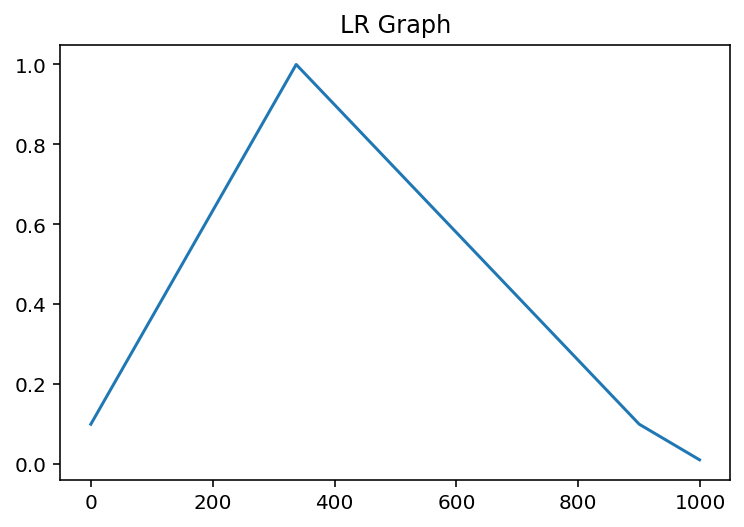

In [8]:



def min_max_scaler(iterations, num_iterations, end_percentage, min_val, max_val, invert = False, triangle_tilt = 0.75):
  non_slant_mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
  mid_cycle_id = int(triangle_tilt*int(num_iterations * ((1. - end_percentage)) / float(2)))
  value = 0
  if iterations > 2 * non_slant_mid_cycle_id:
    
    
      extra_iters = (iterations - 2 * non_slant_mid_cycle_id)
      current_percentage = 1 - (1 - 1/10)*extra_iters/(num_iterations - 2 * non_slant_mid_cycle_id)
            

  elif iterations >  mid_cycle_id:
      current_percentage = 1. - (iterations - mid_cycle_id) / (2*non_slant_mid_cycle_id - mid_cycle_id)
      
  else:
      current_percentage = iterations / mid_cycle_id
      
  if invert:
    if iterations > 2 * non_slant_mid_cycle_id:
      return max_val
    return max_val - current_percentage * (max_val - min_val)
  else:
    if iterations > 2 * non_slant_mid_cycle_id:
      return min_val * current_percentage
    return min_val + current_percentage * (max_val - min_val)
  
    

print("="*80)
scales = []
for i in range(1000):
  p = min_max_scaler(i,1000,0.1,min_val=0.1,max_val=1, invert=False)
  scales.append(p)
  
plt.plot(np.array(scales))
plt.title("LR Graph")
plt.show()

# scales = []
# for i in range(1000):
#   p = min_max_scaler(i,1000,0.1,min_val=0.85,max_val=0.95, invert=True)
#   scales.append(p)
  
# plt.plot(np.array(scales))
# plt.title("Momentum Graph")
# plt.show()

## One Cycle LR

In [0]:
import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 triangle_tilt = 0.75,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        new_lr = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.initial_lr/self.scale, self.initial_lr, invert = False, triangle_tilt=triangle_tilt)
        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """    
        new_momentum = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.min_momentum, self.max_momentum, invert = True, triangle_tilt=triangle_tilt)
        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))
                
    
    def plot(self):
        plt.title("LR-Plot")
        plt.plot(self.history['lr'])
        plt.xlabel("Epochs")
        plt.ylabel("LR")
        plt.show()
        
        plt.title("Momentum-Plot")
        plt.plot(self.history['momentum'])
        plt.xlabel("Epochs")
        plt.ylabel("Momentum")
        plt.show()



## Loss Fn

In [0]:
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow_probability as tfp
import tensorflow as tf
def get_L2_enhanced_loss(model):
  conv_layers = [layer for layer in model.layers if type(layer)==Convolution2D and layer.trainable_weights[0].shape.as_list()[0]>0]
  conv_layers = conv_layers[:-1]
  def L2_enhanced():
    total_loss = K.variable(0)
    for layer in conv_layers:
      weights = layer.trainable_weights[0]
      total_loss = total_loss + tf.nn.l2_loss(weights)
    return total_loss
  return L2_enhanced

        
  
def get_combined_L2_cross_entropy_loss(model,alpha,batch_size,total_data_size,
                                      epochs, end_percentage=0.1, scale=100):
  l2_loss = get_L2_enhanced_loss(model, )
  iters_per_epoch = int(np.ceil(total_data_size/batch_size))
  num_iterations = epochs*iters_per_epoch
  mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
  container ={"iterations":0}
  sess = K.get_session()
  
  
    
  def combined_loss(y_true, y_pred):
    container['iterations'] = container['iterations'] + 1
    iterations = container['iterations']
    
    # new_alpha = min_max_scaler(iterations, num_iterations, end_percentage, alpha/scale, alpha, invert = False)
    
    new_alpha = alpha
    
    loss = categorical_crossentropy(y_true, y_pred) + new_alpha * l2_loss()
    return loss
  return combined_loss

## Resnet Functions

In [0]:


class StopAtAccValue(Callback):
  def __init__(self,validation_iterator, threshold = 0.9, ):
    super(StopAtAccValue, self).__init__()
    self.threshold = threshold
    self.validation_iterator = validation_iterator
  def on_epoch_end(self, epoch, logs={}):
    score = self.model.evaluate_generator(self.validation_iterator,steps=len(self.validation_iterator))
    acc = score[1]
    if acc >= self.threshold:
      self.model.stop_training = True
      print("Stopping Training:: Val Acc = %.3f Achieved"%(acc))
    else:
      print("Continue Training:: Val Acc = %.3f, Threshold = %.3f"%(acc,self.threshold))
      

In [0]:



def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    # kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
    kernel_regularizer = None

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    # kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
    kernel_regularizer = None

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut_mul(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal")(input)

    return multiply([shortcut, residual])
  
def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal")(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        channel_dim = K.int_shape(input)[1:]
        for i in range(repetitions):
            init_strides = (1, 1)
            
            if i == 0 and not is_first_layer and channel_dim[1] > 8:
                init_strides = (2, 2)
            input = block_function(filters=int(filters*(1.25**i)), init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    

class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, 
              growth_rate=1.5, resnet_init_filters = 64, first_conv_filters = 64,):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
            
        double_stride_first = input_shape[1] >= 96 or len(repetitions)<=2
        print("Double Stride in 7x7 =",double_stride_first)
        pool_first = input_shape[1] >= 200
        print("Initial Pooling After 7x7 =",pool_first)

        # Load function from str if needed.
        strides = (2,2) if double_stride_first else (1,1)
          
        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=first_conv_filters, kernel_size=(7, 7), strides=strides)(input)
        print("Shape After 7x7 = ",K.int_shape(conv1)[1:])
        if pool_first:
          pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
        else:
          pool1 = conv1

        block = pool1
        filters = resnet_init_filters
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            print("Filters in Resnet %s = %s, Output Shape = %s"%((i+1),filters, K.int_shape(block)[1:]))
            filters *= growth_rate
            filters = int(filters)

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax", use_bias=False)(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod # 8 
    def build_resnet_9(input_shape, num_outputs,
                      growth_rate=2, resnet_init_filters = 80, first_conv_filters = 80,):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2], 
                                  growth_rate = growth_rate, resnet_init_filters=resnet_init_filters, first_conv_filters=first_conv_filters)
    
    @staticmethod # 8 
    def build_resnet_11(input_shape, num_outputs,
                      growth_rate=2, resnet_init_filters = 80, first_conv_filters = 80,):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 2], 
                                  growth_rate = growth_rate, resnet_init_filters=resnet_init_filters, first_conv_filters=first_conv_filters)
    
    
    
    @staticmethod # 8 
    def build_resnet_13(input_shape, num_outputs,
                      growth_rate=1.75, resnet_init_filters = 64, first_conv_filters = 64,):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2], 
                                  growth_rate = growth_rate, resnet_init_filters=resnet_init_filters, first_conv_filters=first_conv_filters)
    
    
    
    @staticmethod
    def build_resnet_18(input_shape, num_outputs,
                       growth_rate=1.5, resnet_init_filters = 64, first_conv_filters = 64,):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2],
                                  growth_rate = growth_rate, resnet_init_filters=resnet_init_filters, first_conv_filters=first_conv_filters)

    @staticmethod
    def build_resnet_34(input_shape, num_outputs,
                       growth_rate=1.5, resnet_init_filters = 64, first_conv_filters = 64,):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3],
                                  growth_rate = growth_rate, resnet_init_filters=resnet_init_filters, first_conv_filters=first_conv_filters)

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])


# Model

In [13]:
gc.collect()

28

In [14]:
model = ResnetBuilder.build_resnet_13((3, 32, 32), 10)
optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)
model.compile(loss=get_combined_L2_cross_entropy_loss(model,alpha,128,X_train.shape[0], epochs=epochs, end_percentage=end_percentage),
               optimizer=optimizer,
               metrics=['accuracy'])
print("Model Params = ",model.count_params(), ", Metric Names = ",model.metrics_names)

Double Stride in 7x7 = False
Initial Pooling After 7x7 = False
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Shape After 7x7 =  (32, 32, 64)
Filters in Resnet 1 = 64, Output Shape = (32, 32, 80)
Filters in Resnet 2 = 112, Output Shape = (16, 16, 140)
Filters in Resnet 3 = 196, Output Shape = (8, 8, 245)
Model Params =  2380114 , Metric Names =  ['loss', 'acc']


0

Epoch 1/30
Epoch 1/30
 - lr: 0.04802 - momentum: 0.89 
Continue Training:: Val Acc = 0.312, Threshold = 0.900
196/196 - 115s - loss: 1.8329 - acc: 0.3267 - val_loss: 2.0619 - val_acc: 0.3115
Epoch 2/30
Epoch 1/30
 - lr: 0.08624 - momentum: 0.88 
Continue Training:: Val Acc = 0.449, Threshold = 0.900
196/196 - 102s - loss: 1.5159 - acc: 0.4525 - val_loss: 1.8908 - val_acc: 0.4495
Epoch 3/30
Epoch 1/30
 - lr: 0.12446 - momentum: 0.88 
Continue Training:: Val Acc = 0.515, Threshold = 0.900
196/196 - 102s - loss: 1.3528 - acc: 0.5158 - val_loss: 1.6208 - val_acc: 0.5149
Epoch 4/30
Epoch 1/30
 - lr: 0.16267 - momentum: 0.87 
Continue Training:: Val Acc = 0.476, Threshold = 0.900
196/196 - 102s - loss: 1.2255 - acc: 0.5626 - val_loss: 1.8066 - val_acc: 0.4757
Epoch 5/30
Epoch 1/30
 - lr: 0.20089 - momentum: 0.86 
Continue Training:: Val Acc = 0.536, Threshold = 0.900
196/196 - 102s - loss: 1.1252 - acc: 0.6013 - val_loss: 1.5799 - val_acc: 0.5364
Epoch 6/30
Epoch 1/30
 - lr: 0.23911 - moment

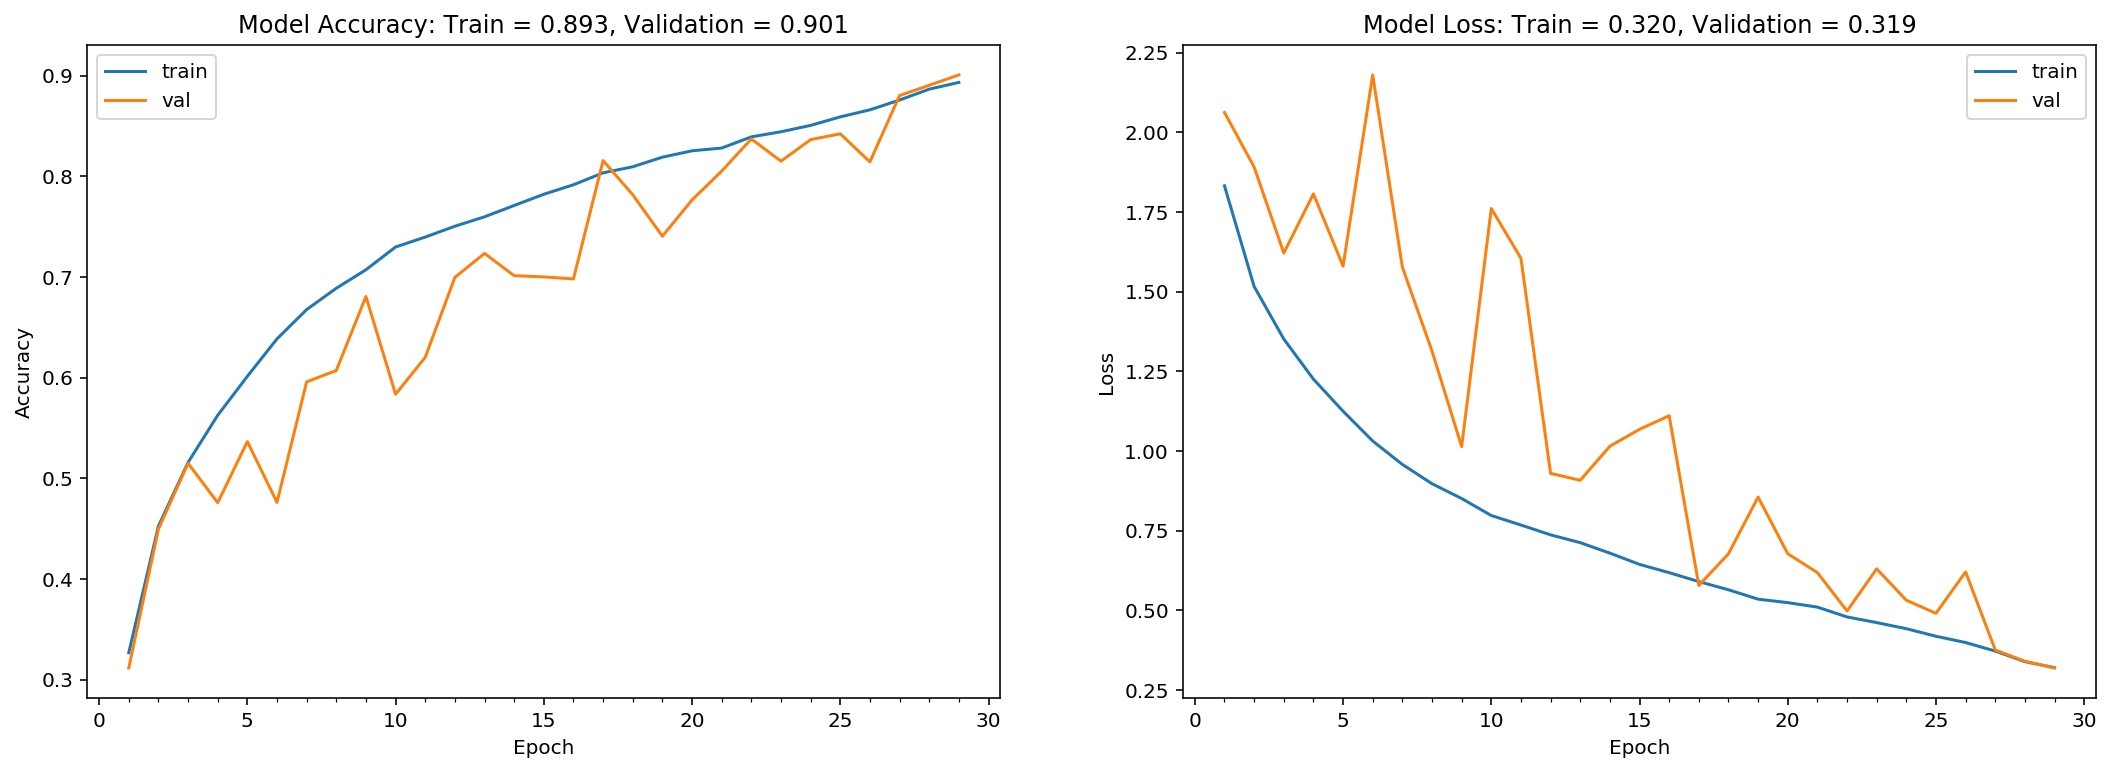

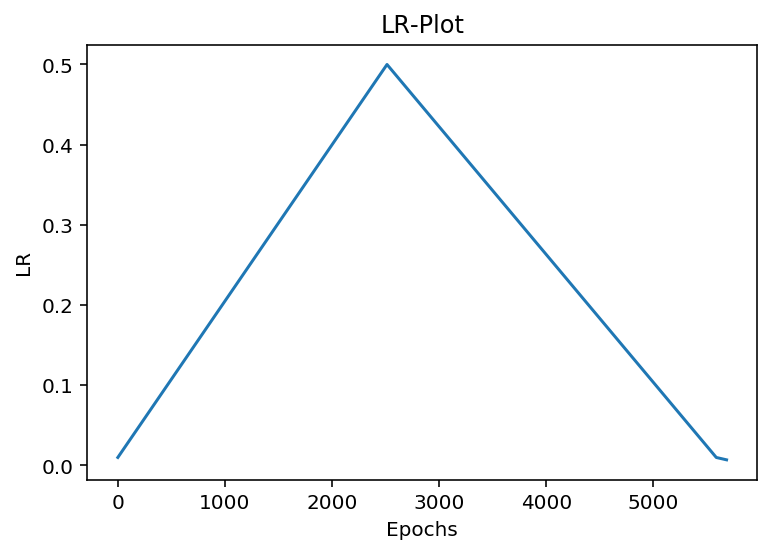

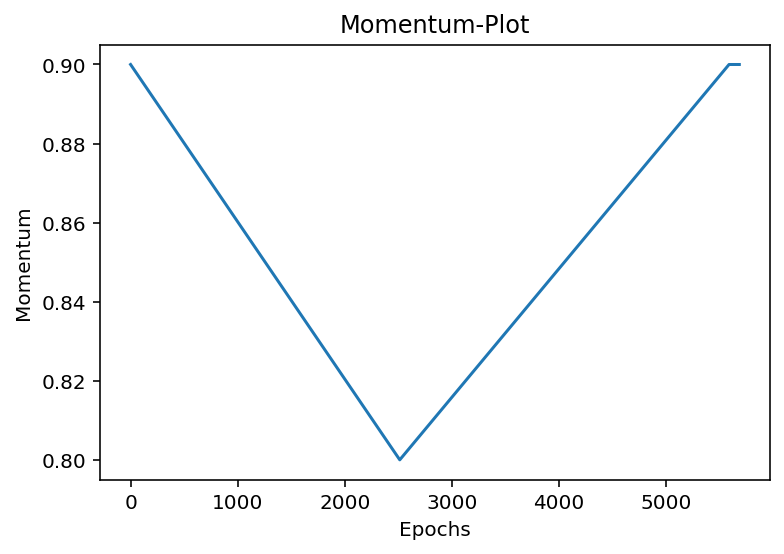

In [15]:
gc.collect()

datagen_validation = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)
datagen_validation.fit(X_test)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')


train_iterator = datagen.flow(X_train, Y_train, batch_size = batch_size,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size,shuffle=True)
stopper = StopAtAccValue(validation_iterator, threshold = 0.9)

olr = OneCycleLR(epochs=epochs, batch_size = batch_size,steps=len(train_iterator), 
                 samples=X_train.shape[0], max_lr=0.5, verbose = True, scale = 50, end_percentage=end_percentage,
                 maximum_momentum = 0.9, minimum_momentum=0.8, triangle_tilt=triangle_tilt)
callbacks=[olr,checkpoint,stopper]
start_time = time.time()
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=epochs, verbose=2,callbacks=callbacks)




end_time = time.time()

print("Time Taken = %.2f"%(end_time-start_time))

# model.load_weights("model.hdf5")


iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)


layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
plot_model_history(train_history,clip_beginning=0)
olr.plot()
